<a href="https://colab.research.google.com/github/hima111997/English-hand-written-recognition/blob/master/English_letters_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand-Written English (capital and small), Numbers, and 4 symbols Characters recognition

## methods:
  * data was downlaoded from Kaggle (https://www.kaggle.com/vaibhao/handwritten-characters) using Kaggle API then extracted
  * data were divided into: 
    * train + valid :  834036 (0.2 valid)
    * test  :  22524
  * CNN model was created
  * data augmentation was used
  * SGD optimizer was used with (lr = .01 and momentum = .09)
  * model was trained for 100 epochs and obtained:
    * train loss: 0.5857 -  train accuracy: 0.8473
    * valid loss: 0.3993 -  valid accuracy: 0.9009
    * test accuracy: 95.1 %
  * metrics were calculated:
    * confusion matrix
    * Precision
    * Recall
    * F1 score

# If you have any advice for making it better, please tell me    
  

# downloading data

In [1]:
!mkdir /root/.kaggle
!mkdir /content/.kaggle
import json
token = {'username':'ibrahimohamed','key':'84672b6ed3b33745eeb4e082de80350d'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json    
!ls  /root/.kaggle
!kaggle config set -n path -v/content



kaggle.json
- path is now set to: /content


In [2]:
# The Data set contains all the English alphabets (small and caps), digits (0-9) and some special characters ( @, #, $, & )
!kaggle datasets download -d vaibhao/handwritten-characters

100% 1.62G/1.62G [00:29<00:00, 82.7MB/s]
100% 1.62G/1.62G [00:29<00:00, 59.2MB/s]


In [0]:
import zipfile, os
with zipfile.ZipFile('/content/datasets/vaibhao/handwritten-characters/handwritten-characters.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/hand_written')

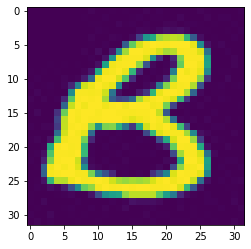

In [0]:
import matplotlib.pyplot as plt

images = os.listdir('/content/hand_written/Train/B')
plt.imshow(plt.imread('/content/hand_written/Train/B/' + images[0]))

In [0]:
train_num = 0
test_num = 0
train_files = os.listdir('/content/hand_written/Train')
valid_files = os.listdir('/content/hand_written/Validation')
for i in train_files:
  all_images = len(os.listdir('/content/hand_written/Train/'+i))
  train_num+= all_images
for i in valid_files:
  all_images = len(os.listdir('/content/hand_written/Validation/'+i))
  test_num+= all_images  
print('train number: ',train_num)
print('test number: ',test_num)

train number:  834036
test number:  22524


# Model

In [0]:
from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform
import datetime
%load_ext tensorboard

inputs = Input(shape = (32,32,3))

X = layers.Conv2D(64, (7,7), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(inputs) #32
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) # 15

X = layers.Conv2D(128, (3,3), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X) # 15
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) #7

X = layers.Conv2D(256, (3,3), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X) # 7
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) # 3

X = layers.GlobalAveragePooling2D()(X) # 256

X = layers.Dense(500, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(250, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(125, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(50, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(39, activation = 'softmax')(X)



log_dir = "/content/drive/My Drive/Colab Notebooks/english_recognition/fit/english_written" #+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


model = Model(inputs = inputs, outputs = X)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 128)       512   

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1/255., 
                               zoom_range = [.8, 1.2],
                               brightness_range=[0.7,1.3],
                               width_shift_range = .5,
                               height_shift_range = .25,
                               shear_range = .3,
                               fill_mode = 'constant',
                               cval = 0,
                               validation_split = .2
                               )

valid_gen = ImageDataGenerator(rescale = 1/255., 
                               validation_split = .2)

train_generator = train_gen.flow_from_directory('/content/hand_written/Train',
                                                 target_size=(32, 32),
                                                 batch_size=32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 subset='training')

valid_generator = valid_gen.flow_from_directory('/content/hand_written/Train',
                                                 target_size=(32, 32),
                                                 batch_size=32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 subset='validation')

Using TensorFlow backend.


Found 667244 images belonging to 39 classes.
Found 166792 images belonging to 39 classes.


In [5]:
steps_per_epoch = int(667244/32)
validation_steps = int(166792/32)

print(steps_per_epoch)
validation_steps

20851


5212

In [0]:
train_generator.class_indices

{'#': 0,
 '$': 1,
 '&': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 '@': 13,
 'A': 14,
 'B': 15,
 'C': 16,
 'D': 17,
 'E': 18,
 'F': 19,
 'G': 20,
 'H': 21,
 'I': 22,
 'J': 23,
 'K': 24,
 'L': 25,
 'M': 26,
 'N': 27,
 'P': 28,
 'Q': 29,
 'R': 30,
 'S': 31,
 'T': 32,
 'U': 33,
 'V': 34,
 'W': 35,
 'X': 36,
 'Y': 37,
 'Z': 38}

In [0]:
optim = optimizers.SGD(lr = .01, momentum=.09)
model.compile(optimizer = optim,
              loss = 'categorical_crossentropy', # classes as integers
              metrics=['accuracy',
                       Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

# start training

In [0]:
model.fit(train_generator,
          epochs = 10,
          validation_data = valid_generator,
          steps_per_epoch = steps_per_epoch,
          validation_steps = validation_steps,
          callbacks=[tensorboard_callback],
          verbose = 2)
# loss: 0.5857 - accuracy: 0.8473   val_loss: 0.3993 - val_accuracy: 0.9009 at epoch 20

Epoch 1/10
20851/20851 - 1125s - loss: 0.6993 - accuracy: 0.8151 - recall: 0.7459 - precision: 0.8828 - auc: 0.9857 - auc_1: 0.8843 - val_loss: 0.4583 - val_accuracy: 0.8874 - val_recall: 0.8699 - val_precision: 0.9129 - val_auc: 0.9888 - val_auc_1: 0.9351
Epoch 2/10
20851/20851 - 1109s - loss: 0.6783 - accuracy: 0.8219 - recall: 0.7565 - precision: 0.8855 - auc: 0.9862 - auc_1: 0.8898 - val_loss: 0.5965 - val_accuracy: 0.8809 - val_recall: 0.8595 - val_precision: 0.9011 - val_auc: 0.9840 - val_auc_1: 0.9155
Epoch 3/10
20851/20851 - 1125s - loss: 0.6625 - accuracy: 0.8269 - recall: 0.7639 - precision: 0.8879 - auc: 0.9865 - auc_1: 0.8941 - val_loss: 0.5074 - val_accuracy: 0.8801 - val_recall: 0.8648 - val_precision: 0.9033 - val_auc: 0.9871 - val_auc_1: 0.9276
Epoch 4/10
20851/20851 - 1115s - loss: 0.6451 - accuracy: 0.8312 - recall: 0.7707 - precision: 0.8905 - auc: 0.9869 - auc_1: 0.8981 - val_loss: 0.5469 - val_accuracy: 0.8900 - val_recall: 0.8751 - val_precision: 0.9071 - val_auc:

In [0]:
model.save('english_handwrittenV2')
!zip -r /content/english_handwrittenV2.zip /content/english_handwrittenV2
from google.colab import files
files.download("/content/english_handwrittenV2.zip")

INFO:tensorflow:Assets written to: english_handwrittenV2/assets
  adding: content/english_handwrittenV2/ (stored 0%)
  adding: content/english_handwrittenV2/saved_model.pb (deflated 90%)
  adding: content/english_handwrittenV2/variables/ (stored 0%)
  adding: content/english_handwrittenV2/variables/variables.data-00001-of-00002 (deflated 10%)
  adding: content/english_handwrittenV2/variables/variables.data-00000-of-00002 (deflated 81%)
  adding: content/english_handwrittenV2/variables/variables.index (deflated 73%)
  adding: content/english_handwrittenV2/assets/ (stored 0%)


# continue training

In [0]:
with zipfile.ZipFile('/content/english_handwrittenV9.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/english_handwrittenV9')    

In [0]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras import optimizers

model = load_model('/content/english_handwrittenV9/content/english_handwrittenV9')
optim = optimizers.SGD(lr = .01, momentum=.09)
model.compile(optimizer = optim,
              loss = 'categorical_crossentropy', # classes as integers
              metrics=['accuracy',
                       Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

In [0]:
import datetime
log_dir = "/content/drive/My Drive/Colab Notebooks/english_recognition/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1/255., 
                               zoom_range = [.8, 1.2],
                               brightness_range=[0.7,1.3],
                               width_shift_range = .5,
                               height_shift_range = .25,
                               shear_range = .3,
                               fill_mode = 'constant',
                               cval = 0,
                               validation_split = .2
                               )

valid_gen = ImageDataGenerator(rescale = 1/255., 
                               validation_split = .2)

train_generator = train_gen.flow_from_directory('/content/hand_written/Train',
                                                 target_size=(32, 32),
                                                 batch_size=32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 subset='training')

valid_generator = valid_gen.flow_from_directory('/content/hand_written/Train',
                                                 target_size=(32, 32),
                                                 batch_size=32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 subset='validation')
steps_per_epoch = int(667244/32)
validation_steps = int(166792/32)

In [12]:
model.fit(train_generator,
          epochs = 10,
          validation_data = valid_generator,
          steps_per_epoch = steps_per_epoch,
          validation_steps = validation_steps,
          callbacks=[tensorboard_callback],
          verbose = 2)

Epoch 1/10
20851/20851 - 680s - loss: 0.4400 - accuracy: 0.8836 - recall: 0.8469 - precision: 0.9240 - auc: 0.9919 - auc_1: 0.9434 - val_loss: 0.2842 - val_accuracy: 0.9292 - val_recall: 0.9245 - val_precision: 0.9385 - val_auc: 0.9935 - val_auc_1: 0.9705
Epoch 2/10
20851/20851 - 672s - loss: 0.4400 - accuracy: 0.8845 - recall: 0.8481 - precision: 0.9245 - auc: 0.9919 - auc_1: 0.9436 - val_loss: 0.2900 - val_accuracy: 0.9287 - val_recall: 0.9235 - val_precision: 0.9384 - val_auc: 0.9932 - val_auc_1: 0.9698
Epoch 3/10
20851/20851 - 653s - loss: 0.4365 - accuracy: 0.8853 - recall: 0.8490 - precision: 0.9245 - auc: 0.9920 - auc_1: 0.9443 - val_loss: 0.2567 - val_accuracy: 0.9304 - val_recall: 0.9254 - val_precision: 0.9398 - val_auc: 0.9945 - val_auc_1: 0.9743
Epoch 4/10
20851/20851 - 655s - loss: 0.4368 - accuracy: 0.8849 - recall: 0.8484 - precision: 0.9244 - auc: 0.9919 - auc_1: 0.9439 - val_loss: 0.2900 - val_accuracy: 0.9279 - val_recall: 0.9228 - val_precision: 0.9375 - val_auc: 0.9

In [11]:
model.save('english_handwrittenV10')
!zip -r /content/english_handwrittenV10.zip /content/english_handwrittenV10
from google.colab import files
files.download("/content/english_handwrittenV10.zip")

INFO:tensorflow:Assets written to: english_handwrittenV10/assets
updating: content/english_handwrittenV10/ (stored 0%)
updating: content/english_handwrittenV10/saved_model.pb (deflated 90%)
updating: content/english_handwrittenV10/assets/ (stored 0%)
updating: content/english_handwrittenV10/variables/ (stored 0%)
updating: content/english_handwrittenV10/variables/variables.index (deflated 73%)
updating: content/english_handwrittenV10/variables/variables.data-00000-of-00002 (deflated 81%)
updating: content/english_handwrittenV10/variables/variables.data-00001-of-00002 (deflated 10%)


# Test

In [14]:
test_gen = ImageDataGenerator(rescale = 1/255.)

test_generator = test_gen.flow_from_directory('/content/hand_written/Validation',
                                                 target_size=(32, 32),
                                                 batch_size=1,
                                                  shuffle=False,
                                                 class_mode = 'categorical'
                                                 )


Found 22524 images belonging to 39 classes.


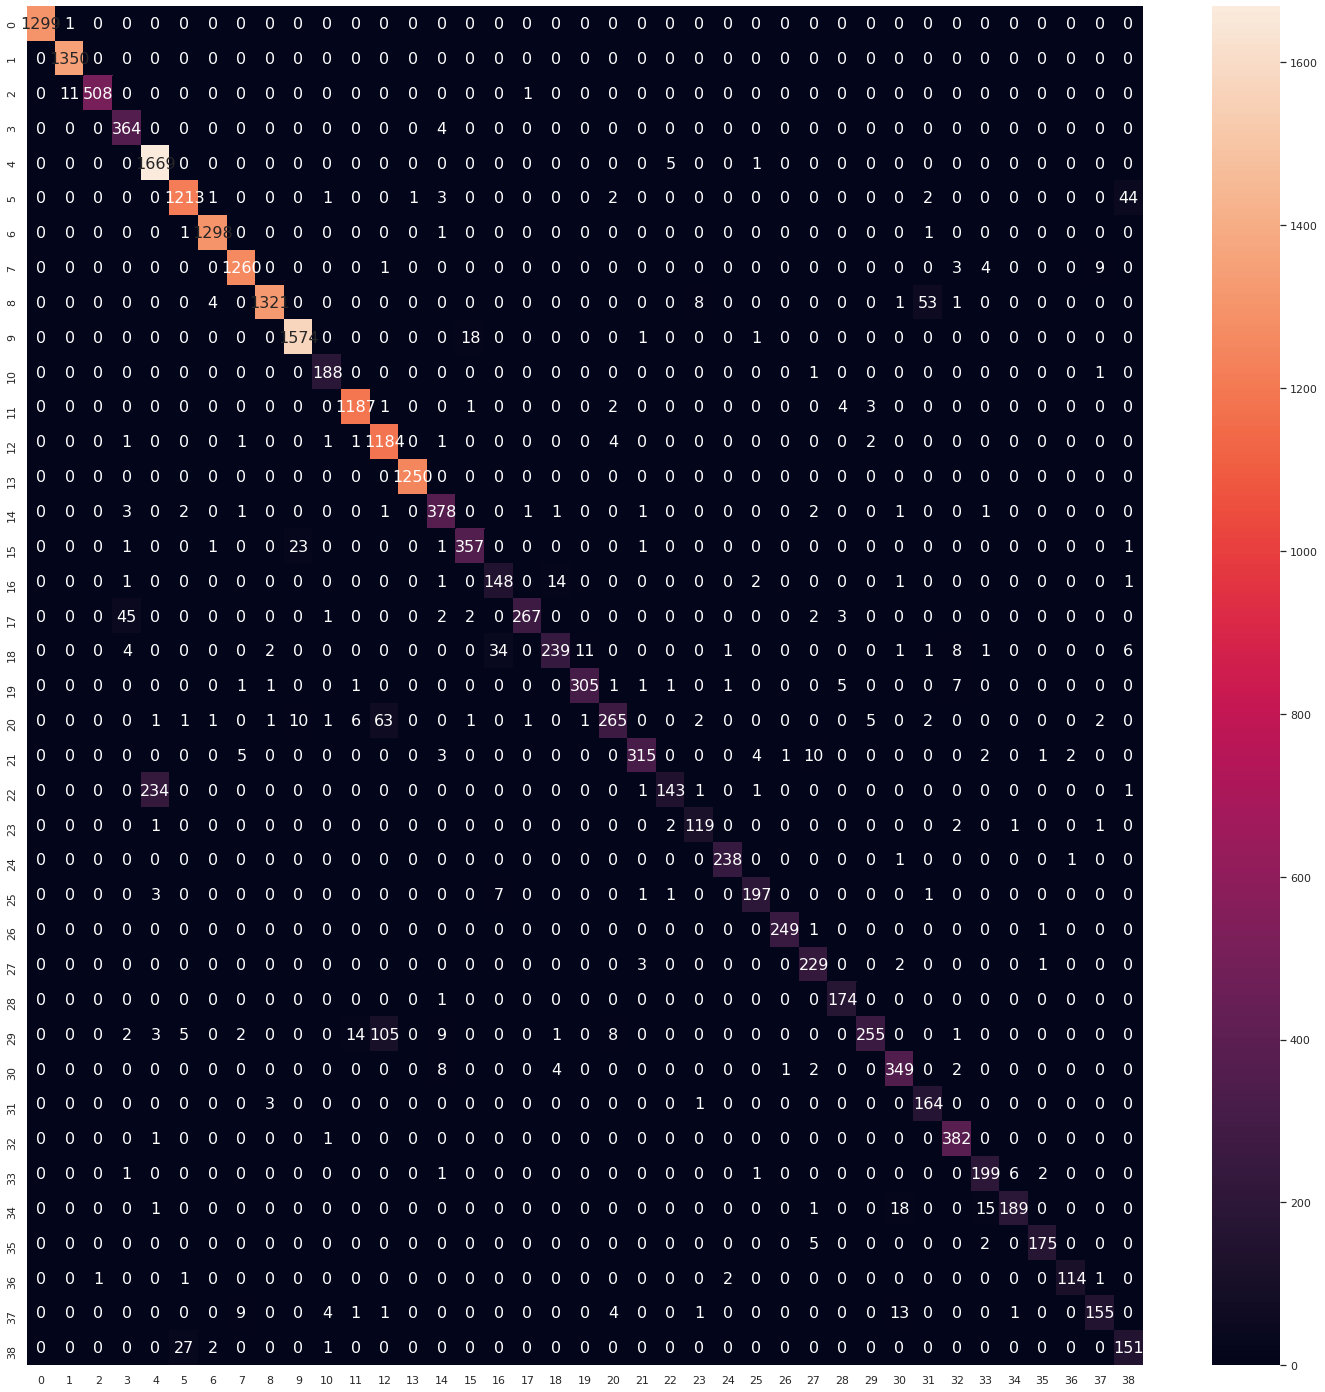

<Figure size 2160x2160 with 0 Axes>

,Precision,Recall,F1_score
0,1.000000,0.999231,0.999615
1,0.991189,1.000000,0.995575
2,0.998035,0.976923,0.987366
3,0.862559,0.989130,0.921519
4,0.872452,0.996418,0.930323
5,0.970400,0.957380,0.963846
6,0.993114,0.997694,0.995399
7,0.985145,0.986688,0.985915
8,0.994729,0.951729,0.972754
9,0.979465,0.987453,0.983443


In [17]:
from sklearn.metrics import precision_recall_fscore_support as score
from tensorflow.math import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator


probabilities = model.predict(test_generator)
y_true = test_generator.classes
y_pred = probabilities.argmax(axis=1)

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(39), range(39))
sn.set(font_scale=1.4) # for label size
sn.set(rc={'figure.figsize':(25,25)})
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt= 'd') # font size
plt.figure(figsize = (30,30))
plt.show()

precision, recall, f1, _ = score(y_true, y_pred)
pd.DataFrame([precision, recall, f1] , index = ['Precision', 'Recall', 'F1_score']).T


In [23]:
mat.diagonal().sum()/mat.sum()

0.9510300124311846

# Showing Some results

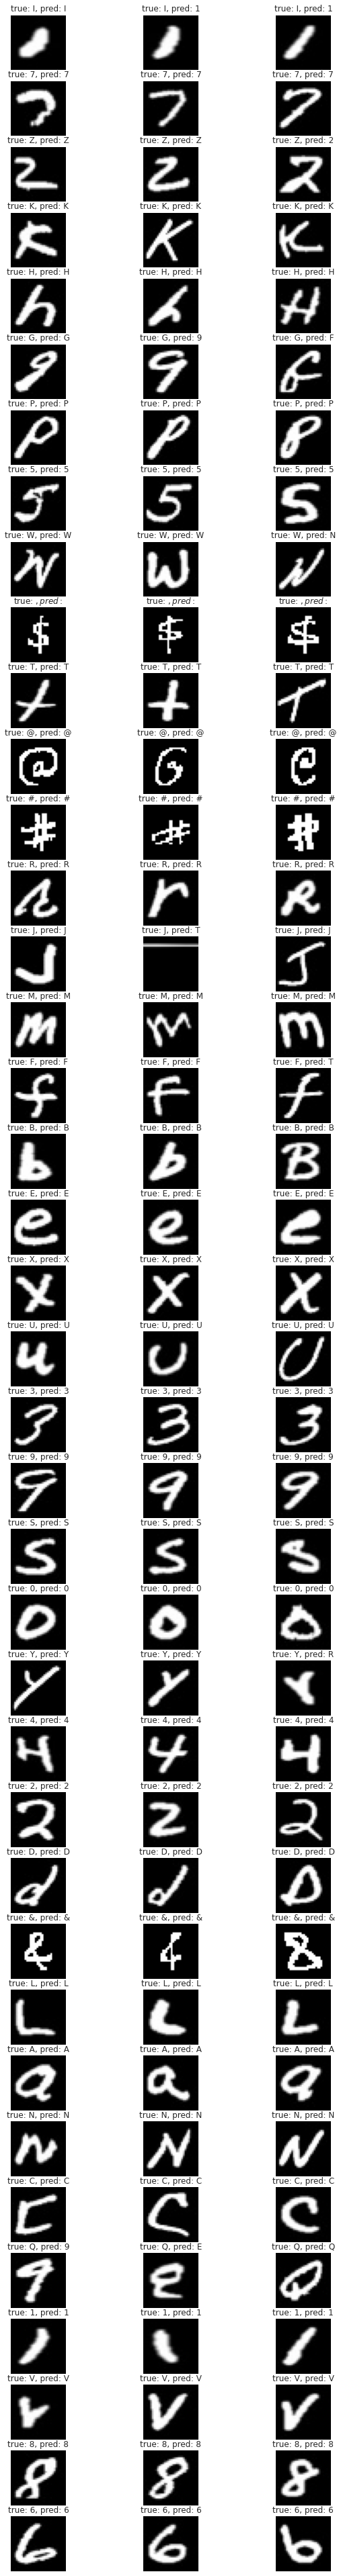

In [29]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np

classes = os.listdir('/content/hand_written/Validation')
idx_class = {str(idx):classes for classes,idx in test_generator.class_indices.items()}
i = 0
plt.figure(figsize=(10,70))
for c in classes:
  imgs = os.listdir('/content/hand_written/Validation/'+c)
  num_files = 0
  for img in imgs:
    plt.subplot(39,3,i+1)
    imga = image.img_to_array(image.load_img('/content/hand_written/Validation/' + c + '/' + img, target_size = (32,32,3)))
    imga_normalized = imga/255.
    imga_add = np.expand_dims(imga_normalized, axis=0)
    
    pred = model.predict(imga_add).argmax(axis = 1)
    plt.grid(b=None)
    plt.axis('off')
    plt.imshow(imga_add[0])
    plt.title('true: {}, pred: {}'.format(c, idx_class[str(pred[0])]))
    
    i+=1
    num_files+=1
    if num_files == 3:
      break

